# 프로젝트: End-to-End OCR
---
케라스에서 제공하는 keras_ocr.detection.Detector 를 사용하여 이미지 내 문자를 검출하고  
Recognition model로 검출된 이미지 영역을 텍스트로 인식하여 출력한다.

|평가문항|상세기준|
|:--|:--|
|1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.|	텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.|
|2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.|학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.|
|3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.|샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.|

---
## Keras Detector

In [36]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

import os
from keras_ocr.detection import Detector

import re
import six
import math
import lmdb

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [63]:
def detect_text(img_path):
    img_pil = PIL.Image.open(img_path)
    img_draw = PIL.ImageDraw.Draw(img_pil)
    img_copy = img_pil.copy()
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    images = [keras_ocr.tools.read(img_path)]
    results = detector.detect(images)
    
    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = results[0]
    
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_copy.crop(word_box))

    return img_pil, cropped_imgs

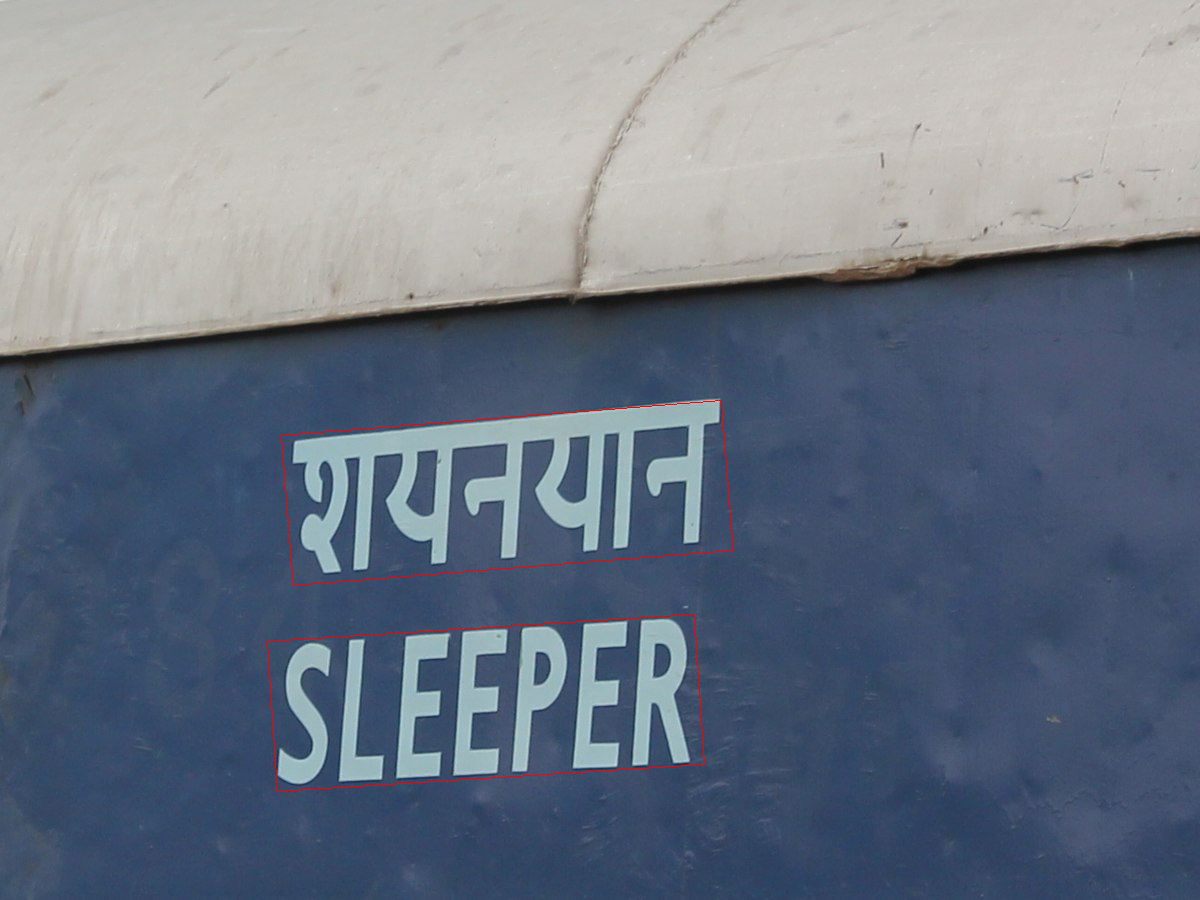

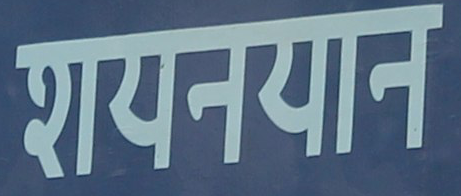

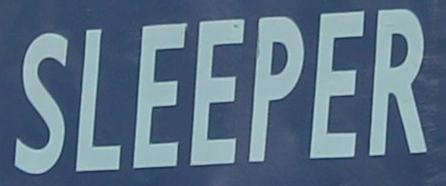

In [64]:
from IPython.display import display

img_pil, cropped_imgs = detect_text(SAMPLE_IMG_PATH)
display(img_pil)
for img in cropped_imgs:
    display(img)

---
## Recognition model

In [39]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


### LMDB Lightning Memory-Mapped Database) MJSynth 데이터셋 준비

In [15]:
BATCH_SIZE = 128

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


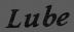

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


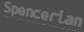

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


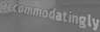

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


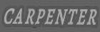

In [16]:
# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [17]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [18]:
class LabelConverter(object):
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

### 모델 학습

In [29]:
label_converter = LabelConverter(TARGET_CHARACTERS)

# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)



In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

checkpoint_path = HOME_DIR + '/crnn_weights.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor="val_loss",  # 모니터링할 지표 (검증 손실)
                             save_best_only=True,  # 가장 좋은 결과만 저장
                             save_weights_only=True,  # 가중치만 저장
                             mode="min")  # 모니터링 지표가 최소화되어야 함

early_stopping = EarlyStopping(monitor="val_loss",  # 모니터링할 지표 (검증 손실)
                               patience=3,  # 훈련이 중지되기 전에 지정된 횟수의 에포크를 기다립니다
                               restore_best_weights=True)  # 최상의 가중치로 복원

history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=30,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[early_stopping, checkpoint]


Epoch 1/30
565/565 [==============================] - 94s 157ms/step - loss: 25.5558 - val_loss: 24.0710
Epoch 2/30
565/565 [==============================] - 86s 152ms/step - loss: 15.1085 - val_loss: 9.3894
Epoch 3/30
565/565 [==============================] - 86s 151ms/step - loss: 7.0775 - val_loss: 6.3294
Epoch 4/30
565/565 [==============================] - 85s 151ms/step - loss: 5.0820 - val_loss: 5.3666
Epoch 5/30
565/565 [==============================] - 85s 151ms/step - loss: 4.0309 - val_loss: 4.6069
Epoch 6/30
565/565 [==============================] - 85s 150ms/step - loss: 3.2933 - val_loss: 4.4022
Epoch 7/30
565/565 [==============================] - 85s 151ms/step - loss: 2.7188 - val_loss: 4.1817
Epoch 8/30
565/565 [==============================] - 85s 149ms/step - loss: 2.2356 - val_loss: 4.2652
Epoch 9/30
565/565 [==============================] - 85s 150ms/step - loss: 1.8233 - val_loss: 4.2253
Epoch 10/30
565/565 [==============================] - 85s 151ms/step 

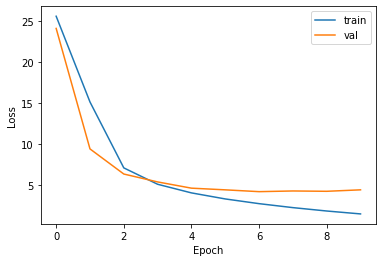

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

---
## End-to-End OCR

In [95]:
# 학습된 모델의 가중치 load
checkpoint_path = HOME_DIR + '/crnn_weights.hdf5'
# checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'
model = build_crnn_model()
model.load_weights(checkpoint_path)

# inference 전용 모델
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_crnn = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:        
        #999 숫자 출력x
        if index == -1:
            continue
        text += chars[index]
    results.append(text)
    return results

def recognize_img(pil_img, input_img_size=(100,32)):
    try:
        img = pil_img.convert('RGB')
    except IOError:
        img = Image.new('RGB', img_size)
        label = '-'
    width, height = img.size
    target_width = min(int(width*input_img_size[1]/height), input_img_size[0])
    target_img_size = (target_width, input_img_size[1])
    resize_img = img.resize(target_img_size)
    img = np.array(resize_img).transpose(1,0,2)
    input_image = np.zeros([1, *input_img_size, 3])
    width = img.shape[0]
    input_image[0,:width,:,:] = img
    output = model_crnn.predict(input_image)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    pil_img.show()
    resize_img.show()
    print("Result: \t", result)

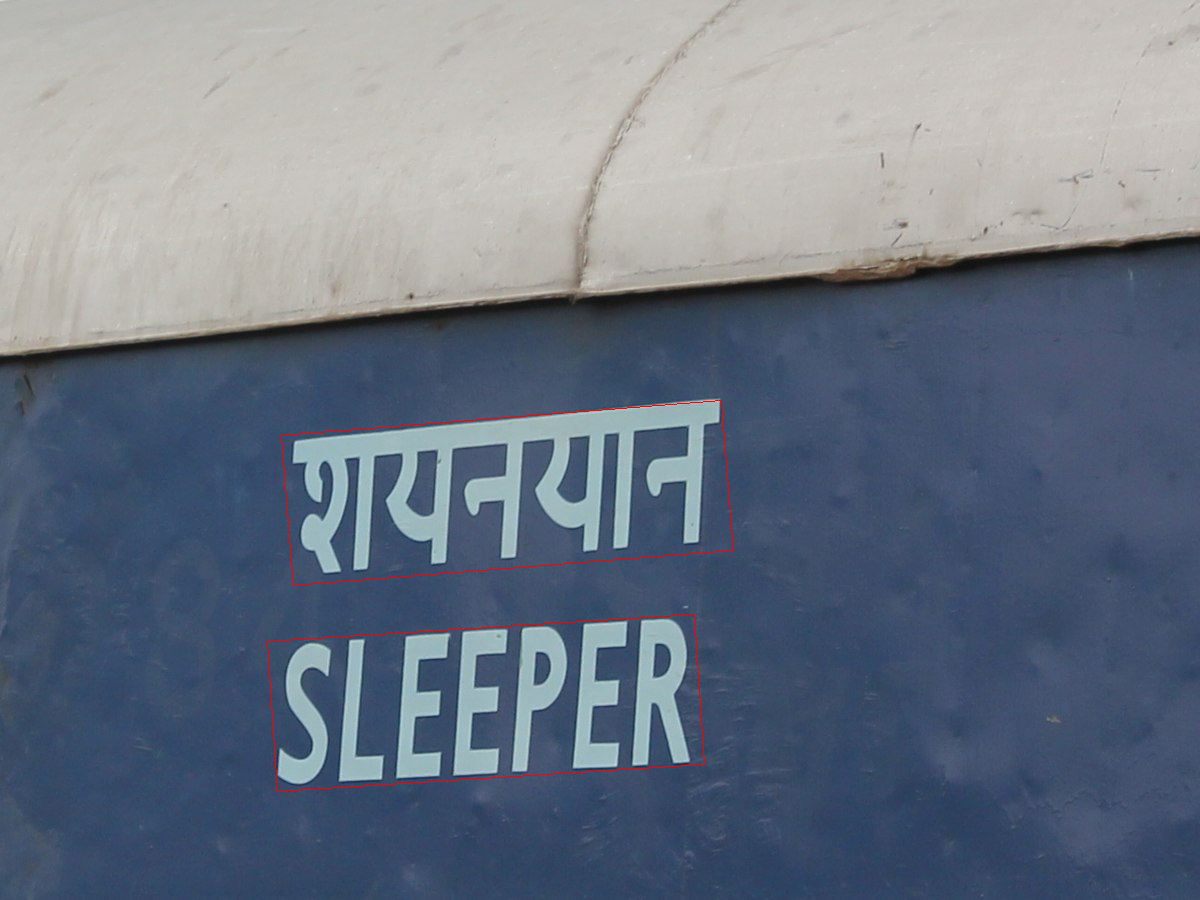

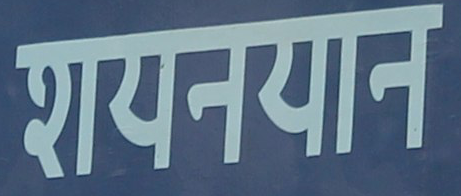

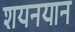

Result: 	 NTAIRL


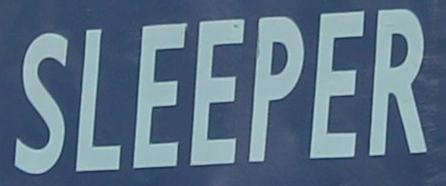

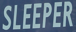

Result: 	 SLEEPER


In [96]:
def ocr(image_path):    
    img_pil, cropped_imgs = detect_text(image_path)
    display(img_pil)
    for img in cropped_imgs:
        recognize_img(img)

ocr(SAMPLE_IMG_PATH)

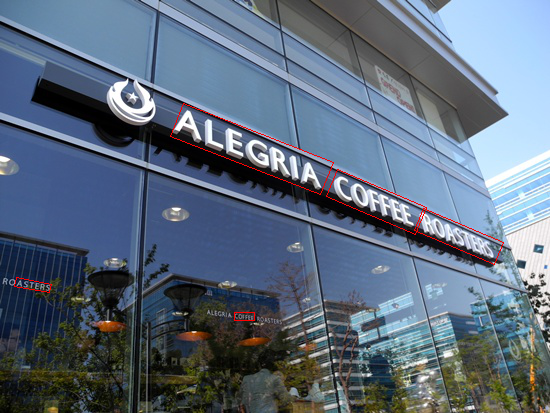

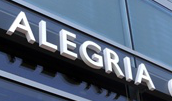

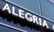

Result: 	 AEOIKS


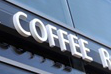

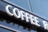

Result: 	 KONS


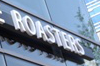

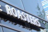

Result: 	 FBAS


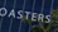

Result: 	 DAITERS


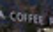

Result: 	 CSCORTI


In [97]:
ocr(HOME_DIR + '/sample2.jpg')

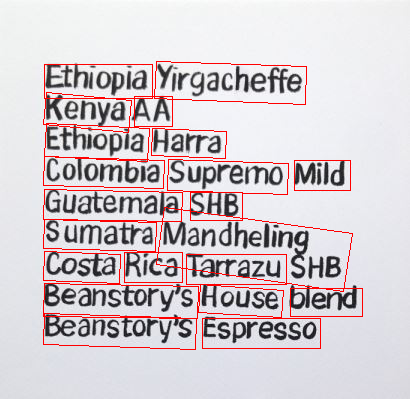

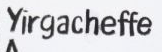

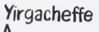

Result: 	 YIRGACHEFIE


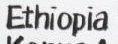

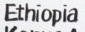

Result: 	 ETHIOPIA


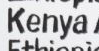

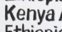

Result: 	 KERYA


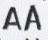

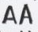

Result: 	 A


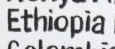

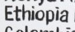

Result: 	 ETHIAPIA


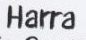

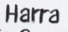

Result: 	 MHARRA


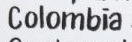

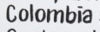

Result: 	 COLOMBIA


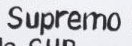

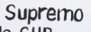

Result: 	 SUPREMO


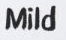

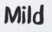

Result: 	 MILD


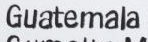

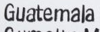

Result: 	 GUATEMALA


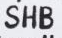

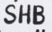

Result: 	 SHB


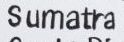

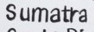

Result: 	 SUMATRA


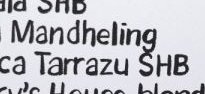

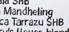

Result: 	 RIAIGIA


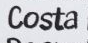

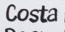

Result: 	 COSTA


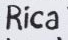

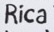

Result: 	 RICA


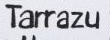

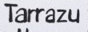

Result: 	 TARRAZU


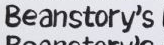

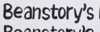

Result: 	 BEANSTORYLS


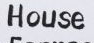

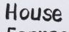

Result: 	 HOUSE


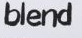

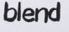

Result: 	 BLEND


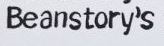

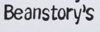

Result: 	 BEANISTORYIS


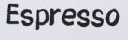

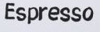

Result: 	 ESPRESSO


In [98]:
ocr(HOME_DIR + '/sample3.jpg')

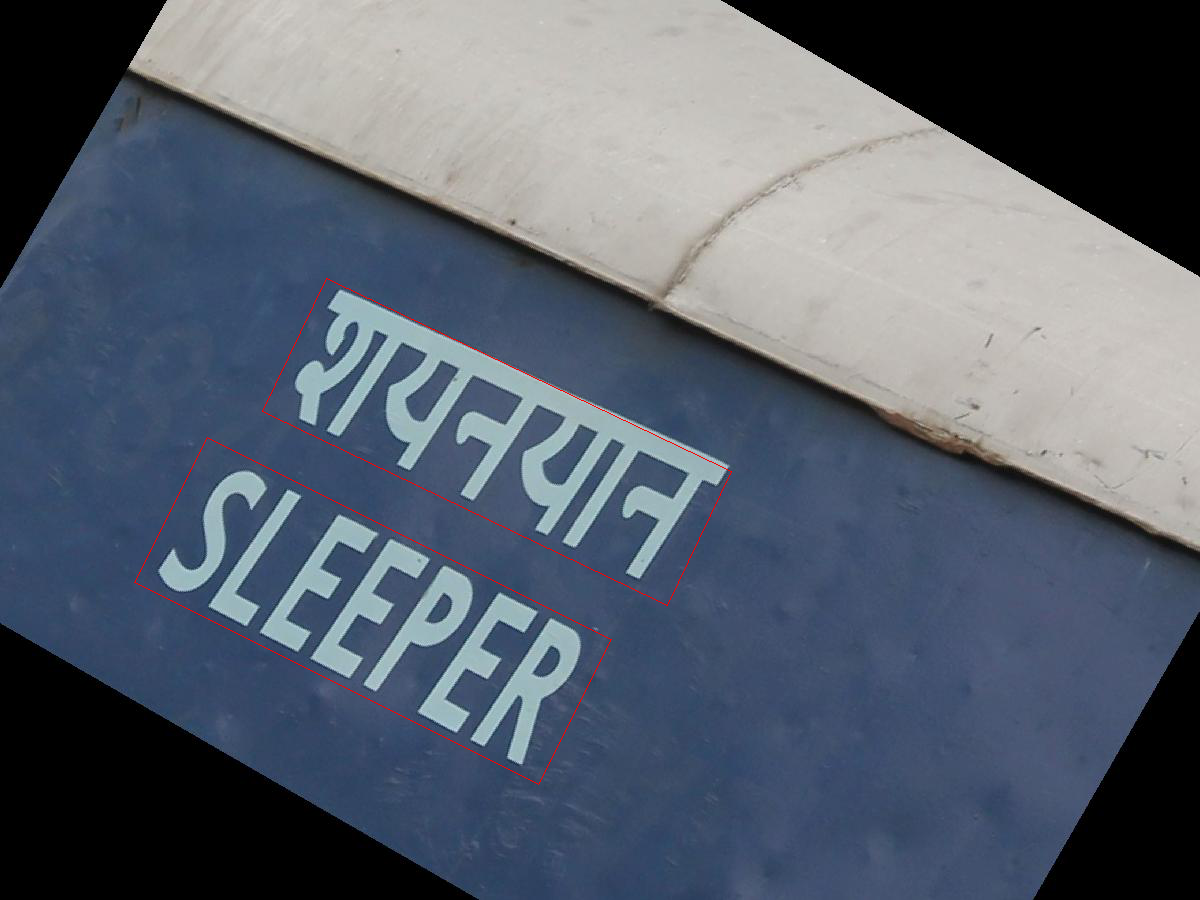

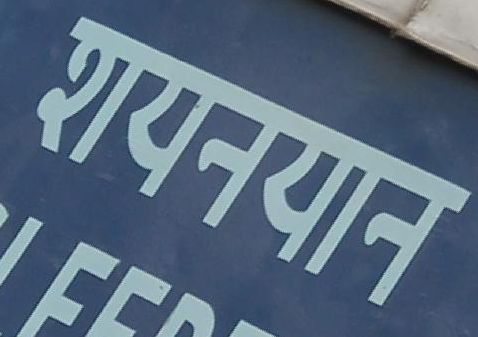

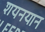

Result: 	 DICOR


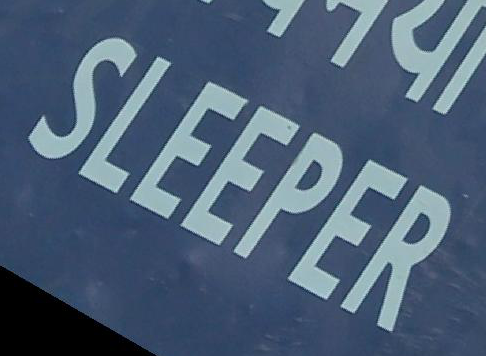

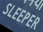

Result: 	 MLARA


In [99]:
rotated_image = PIL.Image.open(SAMPLE_IMG_PATH).rotate(-30)
sample_lotate_path = HOME_DIR + '/sample_lotate_30.jpg'
rotated_image.save(sample_lotate_path)

ocr(sample_lotate_path)

---
## 회고
---
케라스에서 제공하는 keras_ocr.detection.Detector 객체는 텍스트 영역 검출에 좋은 성능을 보여주는 것 같다
하지만 LMDB MJSynth 데이터셋으로 학습시킨 CRNN Recognize 모델의 추론 성능은 이미지에 따라 다른 성능을 보여준다.
#### 1. Sample 이미지 테스트
노드에서 제공된 샘플 이미지는 영문 텍스트를 정확하게 추출하였다
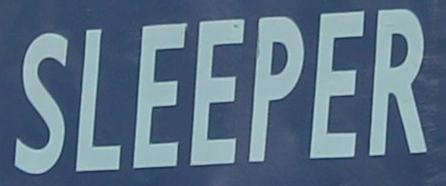  
SLEEPER

#### 2. Sample2 이미지 테스트
샘플이미지와 비교하여 약간 기울어진 사진 이미지로 테스트한 결과 비교적 선명한 이미지임에도 부정확하게 추출되었다
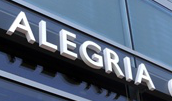   
AEOIKS

#### 3. Sample3 이미지 테스트
손글씨로 평행한 텍스트 이미지로 테스트한 결과 두번째 테스트보다 좋은 성능을 보였다.
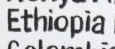  
ETHIOPIA

#### 4. Sample_lotate 이미지 테스트
텍스트 이미지의 회전 상태가 인식 성능에 영향을 주는 것으로 보여
정확하게 추출되었던 샘플 이미지를 회전하여 테스트한 결과 부정확하게 추출되는 것을 확인 할 수 있었다.

### 결론
Recognition 모델의 학습이 충분하지 못한 부분이 있어 노드에서 제공된 학습된 모델의 가중치로 테스트해 본 결과 비슷한 성능을 확인하였다.
따라서 OCR이 어려워지는 이유는 이미지의 불규칙한 방향이나 휘어진 진행 방향 때문인 것으로 보인다.

16번 학습 노드에서 소개된 논문 Robust Scene Text Recognition With Automatic Rectification에서는 Thin Plate Spline (TPS) Transformation을 적용하여 입력 이미지를 단어 영역에 맞게 변형 시켜 인식이 잘되도록 해준다면 인식 성능을 높일 수 있을 것 같다.

추가적으로 Detector로 검출된 텍스트 이미지 영역을 수평하게 회전시켜 Recognition 모델로 추론하는 것으로도 인식 성능을 높일 수 있을 것 같다.


